# Optimisation of a Neocortical Layer 5 Pyramidal Cell

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

**If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:**

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints.
http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492.
http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc 

We first load the bluepyopt python module, the ephys submodule and some helper functionality

In [46]:
!pip -q install neurom --upgrade
!pip -q install http://bbp.courcol.ch:8081/nsg-bluepyopt-job/dist/nsg-bluepyopt-job-0.0.1.dev0.tar.gz

In [47]:
%load_ext autoreload
%autoreload
from __future__ import print_function
import pprint
pp = pprint.PrettyPrinter(indent=2)

import os.path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
!mkdir -p './tmp/'
!curl http://bbp.courcol.ch:8081/hippo-ca1.tar.gz | tar x -C ./tmp
WORKING_DIR = './tmp/hippo-ca1'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5270k  100 5270k    0     0   385M      0 --:--:-- --:--:-- --:--:--  395M


Enable the code below to enable debug level logging

In [2]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

<IPython.core.display.Javascript object>


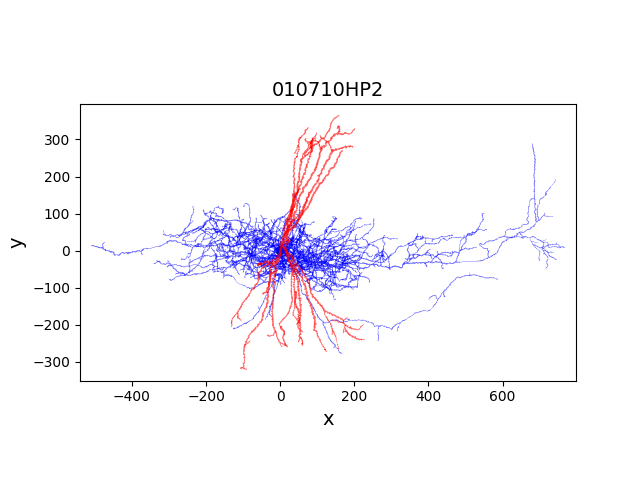

In [19]:
import neurom.viewer
neurom.viewer.draw(neurom.load_neuron(os.path.join(WORKING_DIR, 'morphology', '010710HP2.asc')));

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [28]:
import json
param_configs = json.load(open(os.path.join(WORKING_DIR,'config.orig/parameters.json')))
print(param_configs)

{u'INT_cAC_noljp': {u'distributions': {}, u'optimized': {u'allnoaxon': [[u'ghdbar_hd', 1e-06, 0.0005, u'uniform'], [u'gcalbar_cal', 1e-06, 3e-05, u'uniform'], [u'gcanbar_can', 1e-06, 3e-05, u'uniform'], [u'gcatbar_cat', 1e-06, 3e-05, u'uniform'], [u'gbar_kca', 1e-06, 1e-05, u'uniform'], [u'gbar_cagk', 5e-06, 0.0003, u'uniform'], [u'Ra', 50, 400, u'secvar'], [u'g_pas', 1e-06, 0.0002, u'uniform'], [u'e_pas', -100, -50, u'uniform']], u'alldend': [[u'gbar_nax', 0.005, 0.05, u'uniform'], [u'gkdrbar_kdrb', 0.001, 0.8, u'uniform'], [u'gkabar_kap', 0.001, 0.1, u'uniform']], u'all': [], u'axonal': [[u'gbar_nax', 0.025, 0.15, u'uniform'], [u'gkdrbar_kdrb', 0.01, 0.08, u'uniform'], [u'gkabar_kap', 0.001, 0.04, u'uniform'], [u'gbar_kmb', 0.004, 0.05, u'uniform'], [u'Ra', 50, 300, u'secvar'], [u'g_pas', 1e-06, 8e-05, u'uniform'], [u'e_pas', -95, -75, u'uniform']], u'somatic': [[u'gbar_nax', 0.01, 0.1, u'uniform'], [u'gkdrbar_kdrb', 0.001, 0.08, u'uniform'], [u'gkabar_kap', 0.005, 0.04, u'uniform'],

The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [29]:
proto_configs = json.load(open(os.path.join(WORKING_DIR, 'config.orig/protocols.json')))
print(proto_configs)

{u'INT_cAC_noljp': {u'step_-0.4': {u'stimuli': [{u'delay': 531.0, u'amp': -0.4, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.8': {u'stimuli': [{u'delay': 531.0, u'amp': 0.8, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.2': {u'stimuli': [{u'delay': 531.0, u'amp': 0.2, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.4': {u'stimuli': [{u'delay': 531.0, u'amp': 0.4, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.6': {u'stimuli': [{u'delay': 531.0, u'amp': 0.6, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_-0.2': {u'stimuli': [{u'delay': 531.0, u'amp': -0.2, u'duration': 400.0

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [30]:
feature_configs = json.load(open(os.path.join(WORKING_DIR,'config.orig/features.json')))
pp.pprint(feature_configs)

{ u'INT_cAC_noljp': { u'step_-0.2': { u'soma': { u'voltage_base': [ -74.95850220567962,
                                                                    2.868751014477237],
                                                 u'voltage_deflection': [ -9.859241453008528,
                                                                          1.0756047499453203]}},
                      u'step_-0.4': { u'soma': { u'voltage_base': [ -74.61759546457128,
                                                                    2.1406043489404434],
                                                 u'voltage_deflection': [ -19.772462606879138,
                                                                          2.033148883516023]}},
                      u'step_0.2': { u'soma': { u'Spikecount': [ 0.8333333333333334,
                                                                 1.178511301977579],
                                                u'inv_first_ISI': [ 4.303645236358828,
        

modify configuration here...

## save configuration

In [33]:
for variable, filename in zip([param_configs, proto_configs, feature_configs],['parameters.json', 'protocols.json', 'features.json']):
    with open(os.path.join(WORKING_DIR, 'config', filename), 'w') as f:
        json.dump(variable, f)

In [40]:
!tar -cf './bluepyopt-config.tar.gz' './tmp/hippo-ca1'

In [ ]:
user = 'your_nsg_portal_account'

In [ ]:
password = getpass.getpassword('provide your password')

In [36]:
job_url = job.launch_opt(user, password, './bluepyopt-config.tar.gz')

bluepyopt-config.tar.gz  l5pc	     nsgbluepyopt.ipynb  test_bluepyopt.sh
hippo			 L5PC.ipynb  test_bluepyopt.py	 tmp


In [ ]:
output_url = job.wait_completion(job_url, user_password, 30)

In [ ]:
checkpoint_pkl = job.download_output(output_url, './tmp/')